In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
import sys
from skimage import measure
import cv2
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings('ignore') 

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import stan


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage import measure
import scanpy as sc
import scanpy as sc
import scipy.cluster
from os.path import join

In [3]:
sample_id = "V1_Human_Lymph_Node"
patch_size = 26

In [4]:
adata_filtered=sc.read("./results/"+sample_id+f"{patch_size}*{patch_size}.h5ad")
#make unique names
adata_filtered.var_names_make_unique()

# img_data=np.load("./results/"+sample_id+"_50*50_patches.npy")
# barcodes=np.load("./results/"+sample_id+"_50*50_spots.npy")

In [5]:
adata_filtered

AnnData object with n_obs × n_vars = 3981 × 21261
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'

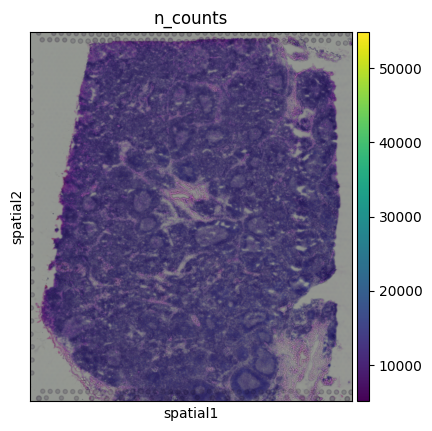

In [6]:

sc.pl.spatial(adata_filtered, color='n_counts', spot_size=10)

In [7]:
#adata_filtered = adata.copy()
adata_filtered.layers['raw'] = adata_filtered.X
adata_filtered.obs['n_counts'] = adata_filtered.to_df('raw').T.sum()

In [8]:
adata_filtered = stan.add_gene_tf_matrix(adata_filtered,
                                min_cells_proportion = 0.2,
                                min_tfs_per_gene= 5,
                                min_genes_per_tf= 10,
                                gene_tf_source="hTFtarget",
                                tf_list="humantfs",
                                source_dir="./data/gene_tf/")
# Assgin folds before training
stan.assign_folds(adata_filtered, n_folds=10, random_seed=1)

## My STAN (changes are commented inside)

In [9]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import scanpy as sc
import random, time
from scipy.stats import spearmanr, pearsonr


def assign_folds(adata, n_folds=5, train_percent=None, random_seed=0):
    random.seed(random_seed)
    if train_percent is not None:
        adata.var["fold"]=np.random.uniform(0,1, adata.n_vars)<train_percent
    else:
        adata.var["fold"]=np.random.randint(0,n_folds, adata.n_vars)
        

class ModelBase:
    def __init__(self, adata, kernel_name = '',layer="dca", gene_tf=None, intercept=False):# add kernel_name
        self.adata = adata
        self.intercept = intercept
        if gene_tf is None:
            gene_tf = adata.varm['gene_tf']

        self.D = gene_tf
        self.Y = adata.to_df(layer).T
        self.genes = np.intersect1d(self.Y.index, self.D.index)
        self.D = self.D.loc[self.genes]
        self.Y = self.Y.loc[self.genes]

        self.n_folds = np.max(adata.var['fold']) + 1
        self.n_genes = len(self.genes)
        self.n_spots = adata.n_obs
        self.n_tfs = self.D.shape[1]

        self.training_genes = [adata.var.query("fold != @i").index for i in range(self.n_folds)]
        self.testing_genes = [adata.var.query("fold == @i").index for i in range(self.n_folds)]
        self.D_train = [self.D.loc[self.training_genes[i]].to_numpy() for i in range(self.n_folds)]
        self.D_test = [self.D.loc[self.testing_genes[i]].to_numpy() for i in range(self.n_folds)]
        self.Y_train = [self.Y.loc[self.training_genes[i]].to_numpy() for i in range(self.n_folds)]
        self.Y_test = [self.Y.loc[self.testing_genes[i]].to_numpy() for i in range(self.n_folds)]
        self.D = self.D.to_numpy()

        self.K = adata.obsm.get(kernel_name) #changed 'kernel' to kernel_name
        self.svdD = []
        for i in range(self.n_folds):
            self.svdD.append(np.linalg.svd(self.D_train[i], full_matrices=False))
        self.svdK = None

        self.W = [None] * self.n_folds
        self.y_pred = [None] * self.n_folds


    def evaluate(self, fold=0, gene_set="testing"):
        if fold == -1:
            y_pred = np.asarray(self.y_pred_concat)
            Y = np.asarray(self.Y)
        else:
            W = self.W[fold]
            if gene_set == "testing":
                Y = self.Y_test[fold]
                D = self.D_test[fold]
            elif gene_set == "training":
                Y = self.Y_train[fold]
                D = self.D_train[fold]
            y_pred = D.dot(W)
        y_pred = y_pred.astype(float)
        Y = Y.astype(float)
        cor = [pearsonr(y_pred[:, spot], Y[:, spot])[0] for spot in range(self.n_spots)]
        gene_cor = [pearsonr(y_pred[i, :].T, Y[i, :].T)[0] for i in range(Y.shape[0])]
        return cor, gene_cor


    def fit(self, grid_search_params=None, fixed_params=dict(), verbose=False, stages=5, n_steps=5, axis=0):
        t1 = time.time()
        if grid_search_params is None:
            self.params = fixed_params
        else:
            self.params = self.grid_search(n_steps, grid_search_params, fixed_params=fixed_params, verbose=verbose, stages=stages, axis=axis)
        
        params = self.params
        for fold in range(self.n_folds):
            self.train(fold=fold, **params)
            self.y_pred[fold] = self.D_test[fold].dot(self.W[fold])

        self.W_concat = np.mean(self.W, axis=0)
        self.y_pred_concat = pd.DataFrame(data=None, index=self.Y.index, columns=self.Y.columns)

        for fold in range(self.n_folds):
            self.y_pred_concat.loc[self.testing_genes[fold]] = self.y_pred[fold]
        t2 = time.time()
        print('Time elapsed: %.2f seconds'%(t2-t1))


    def grid_search(self, n_steps, params, fixed_params=dict(), verbose=False, stages=2, axis=0):
        if verbose:
            print("stages remaining: " + str(stages))
        param_names = list(params.keys())
        n_params = len(param_names)
        param_steps = [np.log10(params[param_names[i]][1] / params[param_names[i]][0]) / (n_steps - 1) for i in
                       range(n_params)]
        param_mins = [np.log10(params[param_names[i]][0]) for i in range(n_params)]
        perf = list()
        best_perf = -1
        best_params= None
        if verbose:
            pbar = tqdm(range(n_steps ** n_params))
        else:
            pbar = range(n_steps ** n_params)
        for i in pbar:
            step = [(i // (n_steps ** j)) % n_steps for j in range(n_params)]
            params_i = dict(
                [(param_names[j], 10 ** (param_mins[j] + step[j] * param_steps[j])) for j in range(n_params)])
            self.train(**params_i, **fixed_params)
            cor, gene_cor = self.evaluate()
            if np.mean(cor) > best_perf:
                best_perf = np.mean(cor)
                best_params = params_i

        if stages == 1 or best_params is None:
            if best_params is None:
                best_params = params_i
            train_params = {**best_params, **fixed_params}
            self.train(**train_params)
            return train_params
        else:
            params = dict([(param_names[j], [10 ** (np.log10(best_params[param_names[j]]) - param_steps[j]),
                                             10 ** (np.log10(best_params[param_names[j]]) + param_steps[j])]) for j in
                           range(n_params)])
            return self.grid_search(n_steps, params, fixed_params=fixed_params, verbose=verbose, stages=stages-1, axis=axis)


class Ridge(ModelBase):
    def __init__(self, args, **kwargs):
        super().__init__(args, **kwargs)

    def train(self, fold=0, lam=1):
        if self.svdD[fold] is None:
            self.svdD[fold] = np.linalg.svd(self.D_train[fold], full_matrices=False)
        (ua, sa, va) = self.svdD[fold]
        self.W[fold] = va.T.dot(np.diag(1/(lam*self.n_genes+sa**2)).dot(va)).dot(self.D_train[fold].T.dot(self.Y_train[fold]))


class Stan(ModelBase):
    def __init__(self, args, **kwargs):
        super().__init__(args, **kwargs)

    def train(self, fold=0, lam2=1, lam1=5):
        if self.svdD[fold] is None:
            self.svdD[fold] = np.linalg.svd(self.D_train[fold], full_matrices=False)
        if self.svdK is None:
            uk,sk,vk = np.linalg.svd(self.K, full_matrices=True)
            sk = np.concatenate((sk, [0]*(uk.shape[0]-len(sk))))
            self.svdK = (uk,sk,vk)

        [ud,sd,vd] = self.svdD[fold]
        [uk,sk,vk] = self.svdK
        D = self.D_train[fold]
        Y = self.Y_train[fold]

        # scale = np.divide(1, sd.reshape((-1,1))**2+lw*(1-(lw*sk**2/(lw*sk**2+ls))).reshape(1,-1))
        # W = vd.T.dot(np.multiply(scale, vd.dot(D.T.dot(Y)).dot(uk))).dot(uk.T)
        scale = np.divide(1, sd.reshape((-1,1))**2 + lam1*lam2/(lam1*sk**2+lam2).reshape(1,-1))
        W = vd.T@(np.multiply(scale, vd@D.T@Y@uk))@uk.T
        self.W[fold] = W




import time
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix

    
def make_kernel_img(adata,f_name, n=100,kernel_name = '', bandwidth=1, im_feats_weight=0.3):
    t1 = time.time()
    X = np.concatenate((adata.obsm['spatial'][:, 0:2], adata.obsm['pixel'],adata.obsm[f_name]), axis=1)
    x = X.T
    x = (x-x.mean(axis=1).reshape(-1,1))/x.std(axis=1).reshape(-1,1)
    Xn = x.T
    Xn[:, 2:5] = 0.05*Xn[:, 2:5] # as the tutorial
    print(X.shape[1])
    if X.shape[1] > 5:
        Xn[:, 5:X.shape[1]] = im_feats_weight*Xn[:, 5:X.shape[1]]
    pw_dist = squareform(pdist(Xn, 'euclidean'))
    adata.obsp[f_name+'pw_dist'] = pw_dist
    # adata.obsp['kernel'] = (1/(np.sqrt(2)*np.pi*bandwidth)**X.shape[1]) * np.exp(-pw_dist**2 / (2 * bandwidth**2))
    adata.obsp[kernel_name] = (1/(np.sqrt(2*np.pi)*bandwidth)**X.shape[1]) * np.exp(-pw_dist**2 / (2 * bandwidth**2))
    while n>Xn.shape[0]:
        n -= 50
    u,s,v = svds(adata.obsp[kernel_name], n)
    adata.obsm[kernel_name] = u.dot(np.diag(s))
    t2 = time.time()
    print('Time elapsed: %.2f seconds'%(t2-t1))
    

def make_kernel(adata,f_name, n=100,kernel_name = '', bandwidth=1, im_feats_weight=0.3):
    t1 = time.time()
    X = np.concatenate((adata.obsm['spatial'][:, 0:2], adata.obsm['pixel']), axis=1)
    x = X.T
    x = (x-x.mean(axis=1).reshape(-1,1))/x.std(axis=1).reshape(-1,1)
    Xn = x.T
    Xn[:, 2:5] = 0.05*Xn[:, 2:5]
    print(X.shape[1])
    if X.shape[1] > 5:
        Xn[:, 5:X.shape[1]] = im_feats_weight*Xn[:, 5:X.shape[1]]
    pw_dist = squareform(pdist(Xn, 'euclidean'))
    adata.obsp[f_name+'pw_dist'] = pw_dist
    # adata.obsp['kernel'] = (1/(np.sqrt(2)*np.pi*bandwidth)**X.shape[1]) * np.exp(-pw_dist**2 / (2 * bandwidth**2))
    adata.obsp[kernel_name] = (1/(np.sqrt(2*np.pi)*bandwidth)**X.shape[1]) * np.exp(-pw_dist**2 / (2 * bandwidth**2))
    while n>Xn.shape[0]:
        n -= 50
    u,s,v = svds(adata.obsp[kernel_name], n)
    adata.obsm[kernel_name] = u.dot(np.diag(s))
    t2 = time.time()
    print('Time elapsed: %.2f seconds'%(t2-t1))

In [10]:
stan.pixel_intensity(adata_filtered, windowsize=25)

Time elapsed: 0.30 seconds


In [11]:
adata_stan_o= adata_filtered.copy()
adata_stan_bigan= adata_filtered.copy()
adata_stan_dino= adata_filtered.copy()
adata_stan_ae= adata_filtered.copy()
adata_stan_ridge= adata_filtered.copy()

# AE

In [12]:
features_array=np.load('./results/'+sample_id+f"_AE_features{patch_size}.npy")
#remove all zero columns
features_array = features_array[:, ~np.all(features_array == 0, axis=0)]


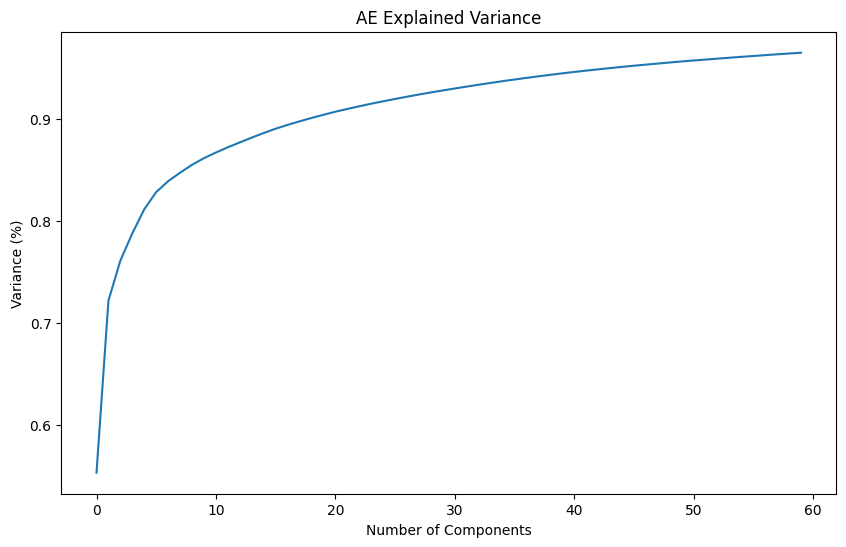

In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=60)
pca_encoded_features_ae = pca.fit_transform(features_array)
pca_encoded_features_ae = pca_encoded_features_ae[:, :30]
scaler = StandardScaler()
norm_ae = scaler.fit_transform(pca_encoded_features_ae)

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('AE Explained Variance')
plt.show()

In [14]:
adata_stan_ae.obsm['ae_feature'] = norm_ae


In [15]:
adata_stan_ae

AnnData object with n_obs × n_vars = 3981 × 8926
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'pixel'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'fold'
    uns: 'spatial', 'tf_names'
    obsm: 'spatial', 'pixel', 'ae_feature'
    varm: 'gene_tf'
    layers: 'raw'

In [16]:
#make_kernel_img(adata_stan_ae, 'ae_feature','kernel_ae' ,n=250, im_feats_weight=0.9, bandwidth=0.2)
make_kernel_img(adata_stan_ae, 'ae_feature',kernel_name='kernel_ae' ,n=250, im_feats_weight=0.01, bandwidth=0.3)# w = 0.01 best,w =0.3 best
#adata_stan_ae.obsm['kernel_ae']=norm_ae

35
Time elapsed: 31.57 seconds


In [17]:
adata_stan_ae.obsm['kernel_ae']

array([[-3.55113964e+01, -1.52961595e+02,  1.36629595e+02, ...,
        -6.76681315e+04,  1.05013739e+04, -4.80444857e+04],
       [ 1.01857020e+01, -7.18927859e+01, -6.59146360e+01, ...,
         4.36035085e+04,  3.17169597e+04, -2.22576167e+04],
       [ 1.87337338e+01,  2.22081607e+01, -3.68503137e+01, ...,
         3.71304315e+04, -5.14444589e+04, -3.38741621e+04],
       ...,
       [ 1.86062369e+01,  8.77333511e+01, -7.05101378e+01, ...,
         7.96963658e+04, -6.24643429e+04, -6.06541265e+04],
       [-1.21170957e+02, -9.58787488e-01,  1.46850068e+02, ...,
         6.71929008e+03, -5.00704523e+04, -3.26700778e+04],
       [-7.69803255e+00,  7.13624286e+01, -2.64042922e+01, ...,
         5.98133792e+04,  5.51711057e+04, -3.72495134e+04]])

In [18]:
sc.pp.normalize_total(adata_stan_ae)
adata_stan_ae.layers['scaled'] = np.sqrt(adata_stan_ae.to_df())

AE_stan_model = Stan(adata_stan_ae, kernel_name='kernel_ae',layer='scaled')
AE_stan_model.K

array([[-3.55113964e+01, -1.52961595e+02,  1.36629595e+02, ...,
        -6.76681315e+04,  1.05013739e+04, -4.80444857e+04],
       [ 1.01857020e+01, -7.18927859e+01, -6.59146360e+01, ...,
         4.36035085e+04,  3.17169597e+04, -2.22576167e+04],
       [ 1.87337338e+01,  2.22081607e+01, -3.68503137e+01, ...,
         3.71304315e+04, -5.14444589e+04, -3.38741621e+04],
       ...,
       [ 1.86062369e+01,  8.77333511e+01, -7.05101378e+01, ...,
         7.96963658e+04, -6.24643429e+04, -6.06541265e+04],
       [-1.21170957e+02, -9.58787488e-01,  1.46850068e+02, ...,
         6.71929008e+03, -5.00704523e+04, -3.26700778e+04],
       [-7.69803255e+00,  7.13624286e+01, -2.64042922e+01, ...,
         5.98133792e+04,  5.51711057e+04, -3.72495134e+04]])

In [19]:
AE_stan_model.fit(n_steps=5, stages=1,
              grid_search_params={'lam1':[1e-4, 1e4], 'lam2':[1e-4, 1e4]})
cor, gene_cor = AE_stan_model.evaluate(fold=-1)
adata_stan_ae.obs['pred_cor_stan_AE'] = cor
adata_stan_ae.var['pred_cor_stan_AE'] = gene_cor
adata_filtered.obs['pred_cor_stan_AE'] = cor
adata_filtered.var['pred_cor_stan_AE'] = gene_cor

adata_stan_ae.obsm['tfa_stan'] = pd.DataFrame(AE_stan_model.W_concat.T, 
                                                    index=adata_stan_ae.obs_names, 
                                                    columns=adata_stan_ae.uns['tf_names'])
#save adata_stan_ae
adata_stan_ae.write('./results/'+sample_id+f'_stan_ae_{patch_size[0]}.h5ad')
print(AE_stan_model.params)
print("Spot-wise correlation:" + str(round(np.nanmedian(cor), 4)))
print("Gene-wise correlation: " + str(round(np.nanmedian(gene_cor), 4)))
del features_array
del AE_stan_model

Time elapsed: 109.39 seconds
{'lam1': 10000.0, 'lam2': 10000.0}
Spot-wise correlation:0.2299
Gene-wise correlation: 0.0929


## BiGAN

In [20]:
#Load data
encoded_features_bigan = np.load('./results/'+sample_id+f"_{patch_size}*{patch_size}_bigan_new_f.npy")

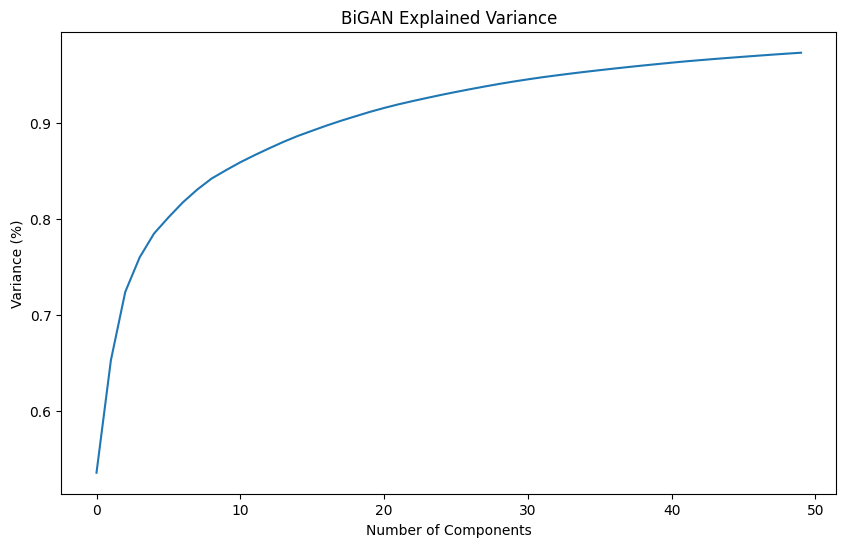

In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pca = PCA(n_components=50)
pca_encoded_features_bigan = pca.fit_transform(encoded_features_bigan)

#save the first 15 components
pca_encoded_features_bigan = pca_encoded_features_bigan[:, :10]

scaler = StandardScaler()
norm_bigan = scaler.fit_transform(pca_encoded_features_bigan)


plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('BiGAN Explained Variance')
plt.show()

In [22]:
adata_stan_bigan.obsm['bigan_feature'] = norm_bigan

In [23]:
make_kernel_img(adata_stan_bigan, 'bigan_feature',kernel_name='kernel_img_bigan' ,n=250, im_feats_weight=0.02, bandwidth=0.26)# w = 0.02 best,w =0.26
#adata_stan_bigan.obsm['kernel_img_bigan'] = norm_bigan

9
Time elapsed: 47.17 seconds


In [24]:
adata_stan_bigan.obsm['kernel_img_bigan'] 

array([[-2.86445734e-02,  7.16605837e-01,  9.62663203e-01, ...,
        -1.04274173e+02, -7.87720682e+00, -7.69100128e+01],
       [ 2.42067630e-01,  4.61978264e-01, -4.94713838e-01, ...,
         6.82742275e+01, -6.03116351e+01, -3.65762872e+01],
       [-1.19582409e+00, -3.65833980e-01,  4.33544025e-02, ...,
         7.35576840e+01,  7.60791522e+01, -5.51897838e+01],
       ...,
       [-2.49579327e-01, -3.29302234e-01,  3.49358799e-04, ...,
         1.57309919e+02,  9.75315579e+01, -1.03227441e+02],
       [ 9.01290770e-02,  1.15491452e-01, -1.51321280e-01, ...,
         2.40792957e+01,  8.05614845e+01, -5.67066912e+01],
       [-3.36534733e-01,  1.89200240e-03,  5.11349397e-02, ...,
         9.70830688e+01, -1.07735776e+02, -6.40675487e+01]])

In [25]:
sc.pp.normalize_total(adata_stan_bigan)

adata_stan_bigan.layers['scaled'] = np.sqrt(adata_stan_bigan.to_df())
BiGAN_stan_model = Stan(adata_stan_bigan, kernel_name='kernel_img_bigan',layer='scaled')
#check the kernel
BiGAN_stan_model.K

array([[-2.86445734e-02,  7.16605837e-01,  9.62663203e-01, ...,
        -1.04274173e+02, -7.87720682e+00, -7.69100128e+01],
       [ 2.42067630e-01,  4.61978264e-01, -4.94713838e-01, ...,
         6.82742275e+01, -6.03116351e+01, -3.65762872e+01],
       [-1.19582409e+00, -3.65833980e-01,  4.33544025e-02, ...,
         7.35576840e+01,  7.60791522e+01, -5.51897838e+01],
       ...,
       [-2.49579327e-01, -3.29302234e-01,  3.49358799e-04, ...,
         1.57309919e+02,  9.75315579e+01, -1.03227441e+02],
       [ 9.01290770e-02,  1.15491452e-01, -1.51321280e-01, ...,
         2.40792957e+01,  8.05614845e+01, -5.67066912e+01],
       [-3.36534733e-01,  1.89200240e-03,  5.11349397e-02, ...,
         9.70830688e+01, -1.07735776e+02, -6.40675487e+01]])

In [26]:
BiGAN_stan_model.fit(n_steps=5, stages=1,
              grid_search_params={'lam1':[1e-4, 1e4], 'lam2':[1e-4, 1e4]})
cor, gene_cor = BiGAN_stan_model.evaluate(fold=-1)
    
print(BiGAN_stan_model.params)
print("Spot-wise correlation:" + str(round(np.nanmedian(cor), 4)))
print("Gene-wise correlation: " + str(round(np.nanmedian(gene_cor), 4)))
adata_stan_bigan.obs['pred_cor_stan_BIGAN'] = cor
adata_stan_bigan.var['pred_cor_stan_BIGAN'] = gene_cor
adata_filtered.obs['pred_cor_stan_BIGAN'] = cor
adata_filtered.var['pred_cor_stan_BIGAN'] = gene_cor

adata_stan_bigan.obsm['tfa_stan'] = pd.DataFrame(BiGAN_stan_model.W_concat.T, 
                                                    index=adata_stan_bigan.obs_names, 
                                                    columns=adata_stan_bigan.uns['tf_names'])
#save adata_stan_bigan
adata_stan_bigan.write('./results/'+sample_id+f'_stan_bigan_{patch_size[0]}.h5ad')

del encoded_features_bigan
del BiGAN_stan_model


Time elapsed: 109.92 seconds
{'lam1': 10000.0, 'lam2': 10000.0}
Spot-wise correlation:0.2299
Gene-wise correlation: 0.0929


## DINO

In [27]:
# load raw features
features_array_dino = np.load('./results/'+sample_id+f"_{patch_size}*{patch_size}_features_array_dino.npy")
features_array_dino = features_array_dino[:, ~np.all(features_array_dino == 0, axis=0)]

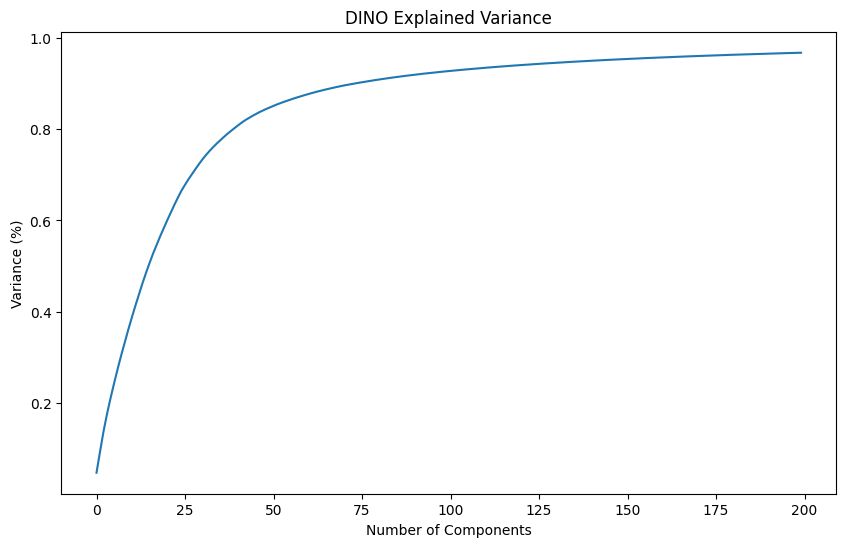

In [28]:
from sklearn.decomposition import PCA

pca = PCA(n_components=200)
pca_features_array_dino = pca.fit_transform(features_array_dino)
pca_features_array_dino = pca_features_array_dino[:, :50]
scaler = StandardScaler()
norm_dino = scaler.fit_transform(pca_features_array_dino)



plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('DINO Explained Variance')
plt.show()

In [29]:
adata_stan_dino.obsm['dino_feature'] = norm_dino

make_kernel_img(adata_stan_dino, 'dino_feature',kernel_name='kernel_img_dino' ,n=250, im_feats_weight=0.01, bandwidth=0.26)
#adata_stan_dino.obsm['kernel_img_dino'] = norm_dino



55
Time elapsed: 76.99 seconds


In [30]:
adata_stan_dino.obsm['kernel_img_dino']

array([[ 5.18791091e+07, -1.58892969e+08,  1.77340624e+07, ...,
        -3.75134195e+10,  4.97567176e+09, -2.80377801e+10],
       [-5.21837586e+07, -1.49877793e+07,  6.90871737e+07, ...,
         2.42732519e+10,  1.93120239e+10, -1.18321712e+10],
       [ 4.91179582e+07,  1.43467164e+08, -7.00134910e+07, ...,
         2.38043726e+10, -2.69781318e+10, -1.86204565e+10],
       ...,
       [-2.06546240e+07,  1.10180939e+07,  1.48323893e+07, ...,
         5.07605747e+10, -3.45448799e+10, -3.41969345e+10],
       [ 3.33139376e+07,  5.56045556e+07,  5.48800461e+07, ...,
         6.99603511e+09, -2.72808870e+10, -1.87643934e+10],
       [-1.08718668e+08, -1.36291051e+08,  6.61758237e+07, ...,
         3.45807870e+10,  3.44269902e+10, -2.05541930e+10]])

In [31]:
sc.pp.normalize_total(adata_stan_dino)

adata_stan_dino.layers['scaled'] = np.sqrt(adata_stan_dino.to_df())
new_stan_model = Stan(adata_stan_dino, kernel_name='kernel_img_dino',layer='scaled')

In [32]:
new_stan_model.K

array([[ 5.18791091e+07, -1.58892969e+08,  1.77340624e+07, ...,
        -3.75134195e+10,  4.97567176e+09, -2.80377801e+10],
       [-5.21837586e+07, -1.49877793e+07,  6.90871737e+07, ...,
         2.42732519e+10,  1.93120239e+10, -1.18321712e+10],
       [ 4.91179582e+07,  1.43467164e+08, -7.00134910e+07, ...,
         2.38043726e+10, -2.69781318e+10, -1.86204565e+10],
       ...,
       [-2.06546240e+07,  1.10180939e+07,  1.48323893e+07, ...,
         5.07605747e+10, -3.45448799e+10, -3.41969345e+10],
       [ 3.33139376e+07,  5.56045556e+07,  5.48800461e+07, ...,
         6.99603511e+09, -2.72808870e+10, -1.87643934e+10],
       [-1.08718668e+08, -1.36291051e+08,  6.61758237e+07, ...,
         3.45807870e+10,  3.44269902e+10, -2.05541930e+10]])

In [33]:
new_stan_model.fit(n_steps=5, stages=1,
              grid_search_params={'lam1':[1e-4, 1e4], 'lam2':[1e-4, 1e4]})
cor, gene_cor = new_stan_model.evaluate(fold=-1)
adata_stan_dino.obs['pred_cor_stan_dino'] = cor

adata_filtered.obs['pred_cor_stan_dino'] = cor
adata_filtered.var['pred_cor_stan_dino'] = gene_cor

print(new_stan_model.params)
print("Spot-wise correlation:" + str(round(np.nanmedian(cor), 4)))
print("Gene-wise correlation: " + str(round(np.nanmedian(gene_cor), 4)))


adata_stan_dino.obsm['tfa_stan'] = pd.DataFrame(new_stan_model.W_concat.T, 
                                                    index=adata_stan_dino.obs_names, 
                                                    columns=adata_stan_dino.uns['tf_names'])

#save adata_stan_dino
adata_stan_dino.write('./results/'+sample_id+f'_stan_dino_{patch_size[0]}.h5ad')
del features_array_dino
del new_stan_model

Time elapsed: 109.37 seconds
{'lam1': 10000.0, 'lam2': 0.0001}
Spot-wise correlation:0.2294
Gene-wise correlation: 0.0884


## Original STAN

In [34]:
stan.make_kernel(adata_filtered, n=250, im_feats_weight=0.05, bandwidth=0.2)


Time elapsed: 50.71 seconds


In [35]:
sc.pp.normalize_total(adata_filtered)
adata_filtered.layers['scaled'] = np.sqrt(adata_filtered.to_df())

In [36]:
o_stan_model = stan.Stan(adata_filtered, layer='scaled')
o_stan_model.fit(n_steps=5, stages=1,
              grid_search_params={'lam1':[1e-4, 1e4], 'lam2':[1e-4, 1e4]})

Time elapsed: 110.22 seconds


In [37]:
cor, gene_cor = o_stan_model.evaluate(fold=-1)
adata_filtered.obs['pred_cor_stan_origin'] = cor
adata_filtered.var['pred_cor_stan_origin'] = gene_cor

print(o_stan_model.params)
print("Spot-wise correlation:" + str(round(np.nanmedian(cor), 4)))
print("Gene-wise correlation: " + str(round(np.nanmedian(gene_cor), 4)))



{'lam1': 10000.0, 'lam2': 0.0001}
Spot-wise correlation:0.2299
Gene-wise correlation: 0.0921


In [38]:

adata_filtered.obsm['tfa_stan'] = pd.DataFrame(o_stan_model.W_concat.T, 
                                                    index=adata_filtered.obs_names, 
                                                    columns=adata_filtered.uns['tf_names'])
adata_filtered.write('./results/'+sample_id+f'_stan_o_{patch_size[0]}.h5ad')

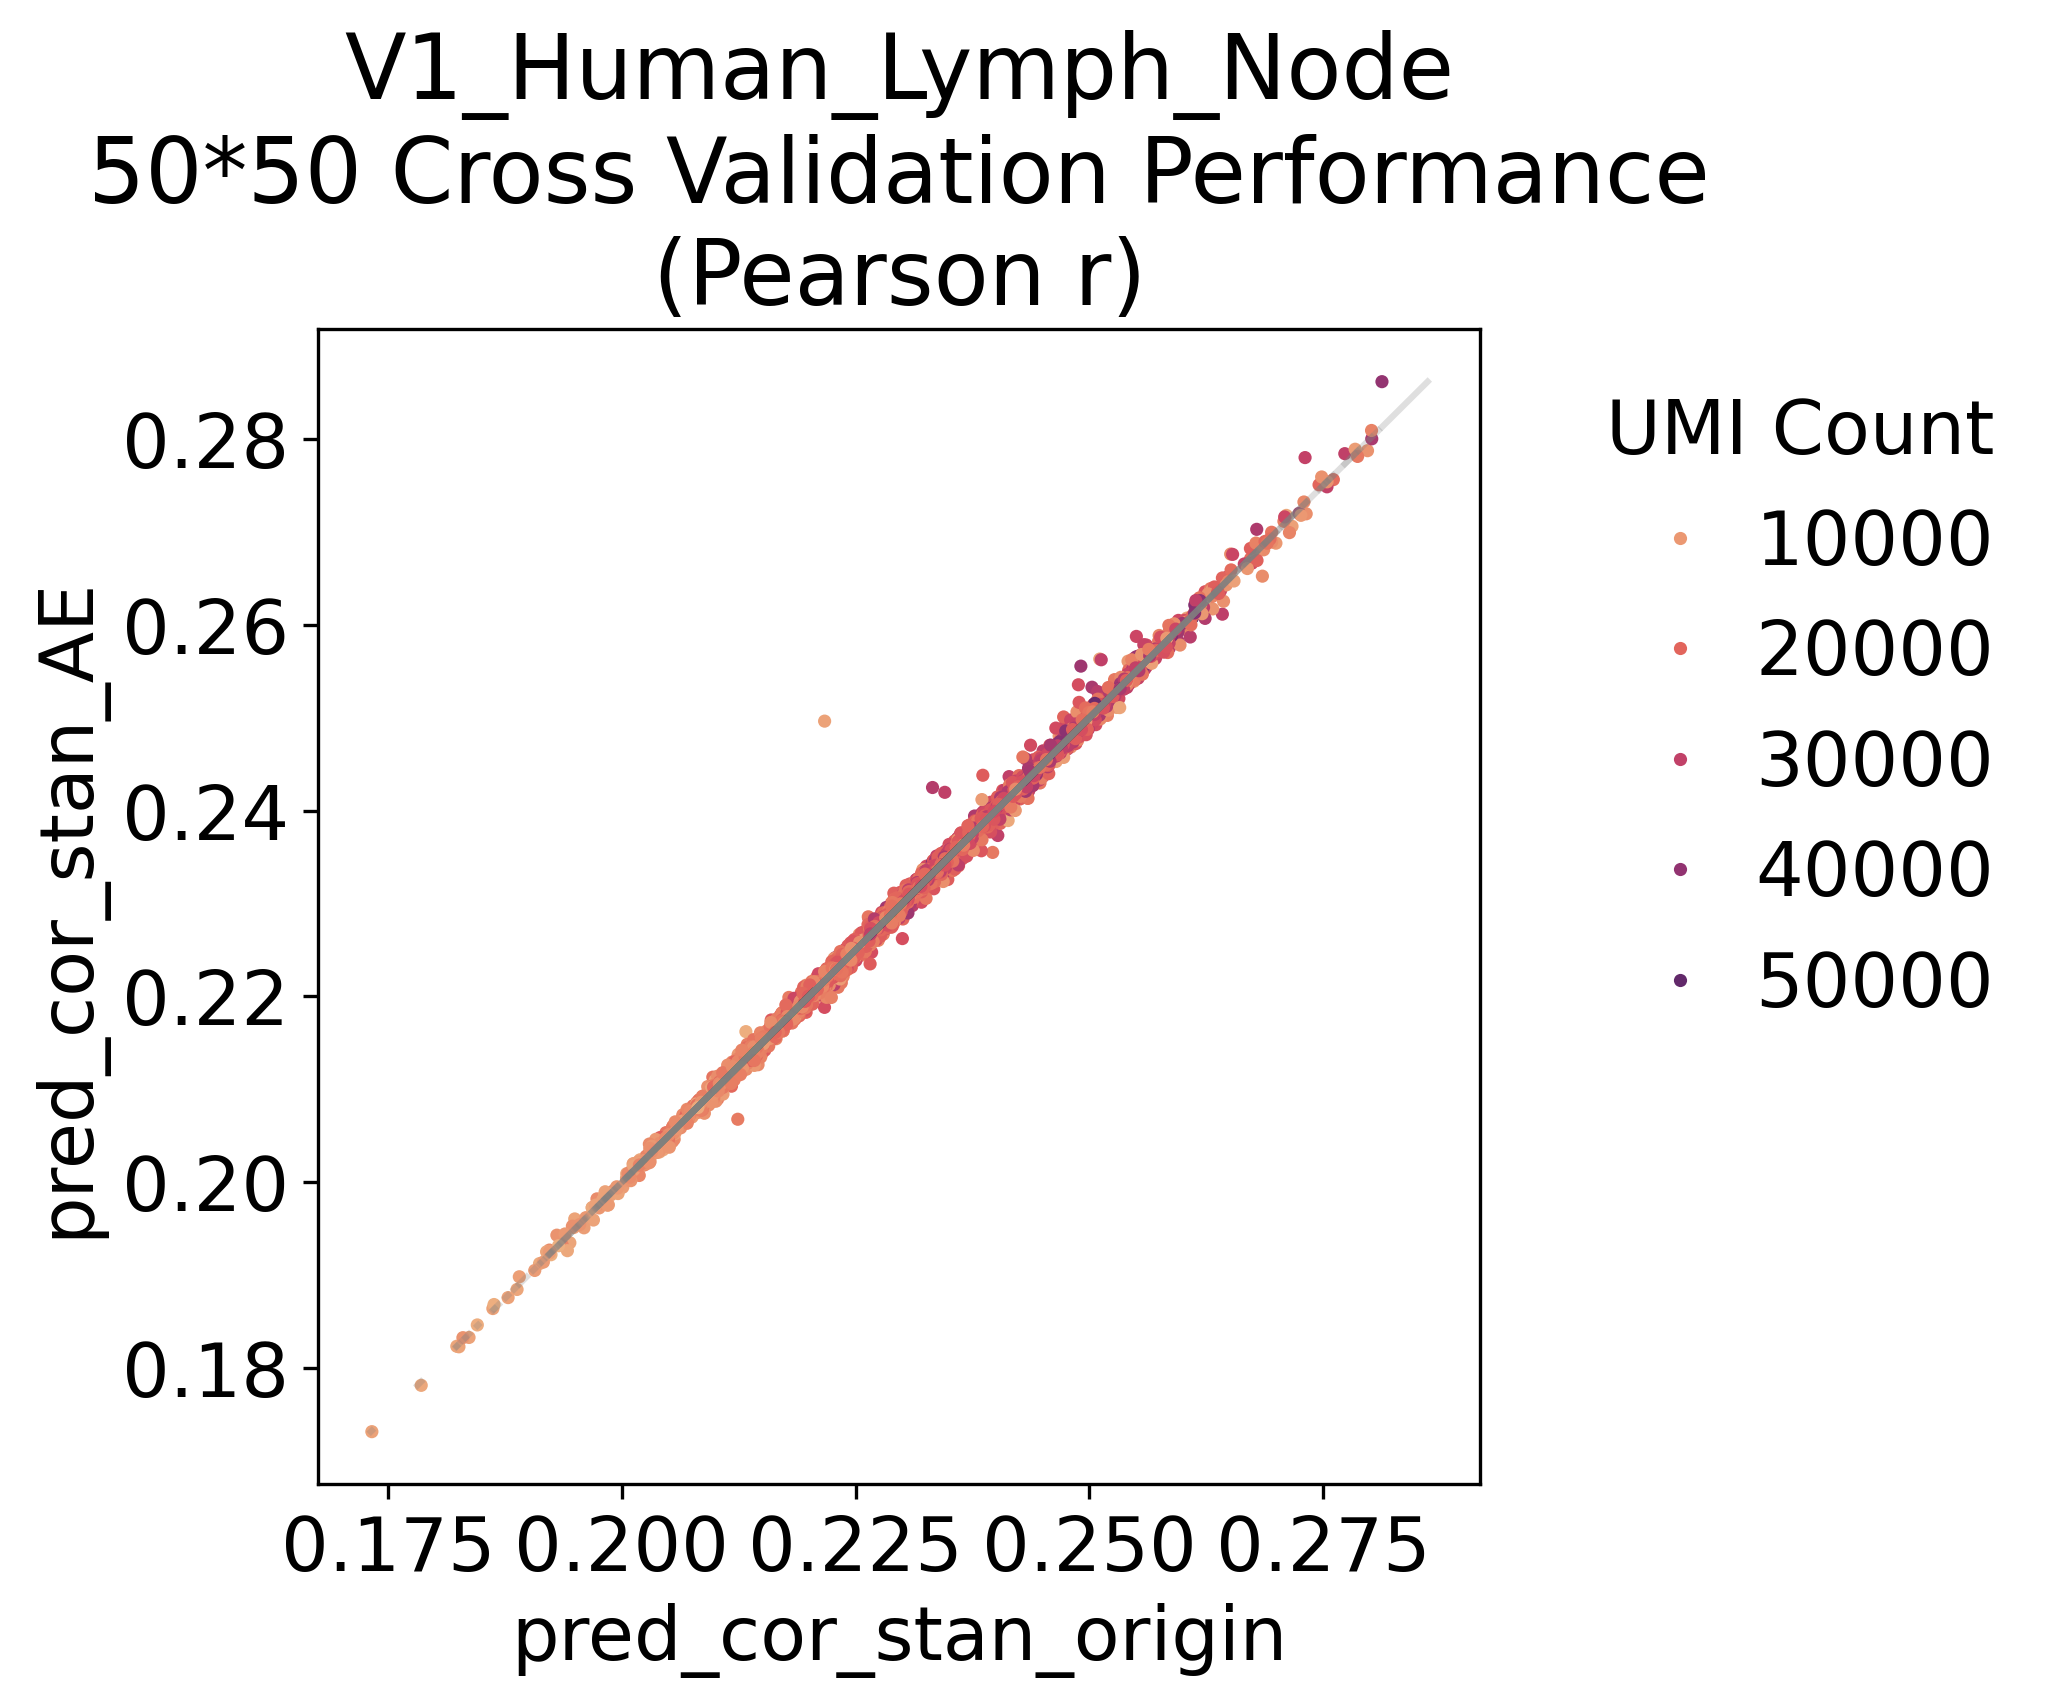

In [42]:
import auxiliary_stan as auxpl
import seaborn as sns
figsize = auxpl.figsize
fontsize = auxpl.fontsize
def plot_validation(adata,xstring = "pred_cor_stan", ystring = "pred_cor_stan_Img"):
    plt.figure(figsize=(figsize, figsize), dpi=300)
    plt.rc('font', size=fontsize) 
    lim_min = np.minimum(adata.obs[xstring], adata.obs[ystring])
    lim_max = np.maximum(adata.obs[xstring], adata.obs[ystring])
    plt.plot([lim_min, lim_max], [lim_min, lim_max], '-', alpha=0.25, color='grey')
    sns.scatterplot(data=adata.obs, x=xstring, y=ystring, s=10, hue="n_counts", linewidth=0, palette='flare')
    plt.ylabel(ystring)
    plt.xlabel(xstring)
    plt.legend(title="UMI Count", loc='upper right', bbox_to_anchor=(1.5, 1), columnspacing=0.5, ncol=1, handletextpad=0, frameon=False)# UMI是Unique Molecular Identifier的缩写，即唯一分子标识符，代表
    plt.title(sample_id+'\n50*50 Cross Validation Performance\n(Pearson r)')

plot_validation(adata_filtered,xstring="pred_cor_stan_origin",ystring="pred_cor_stan_AE")

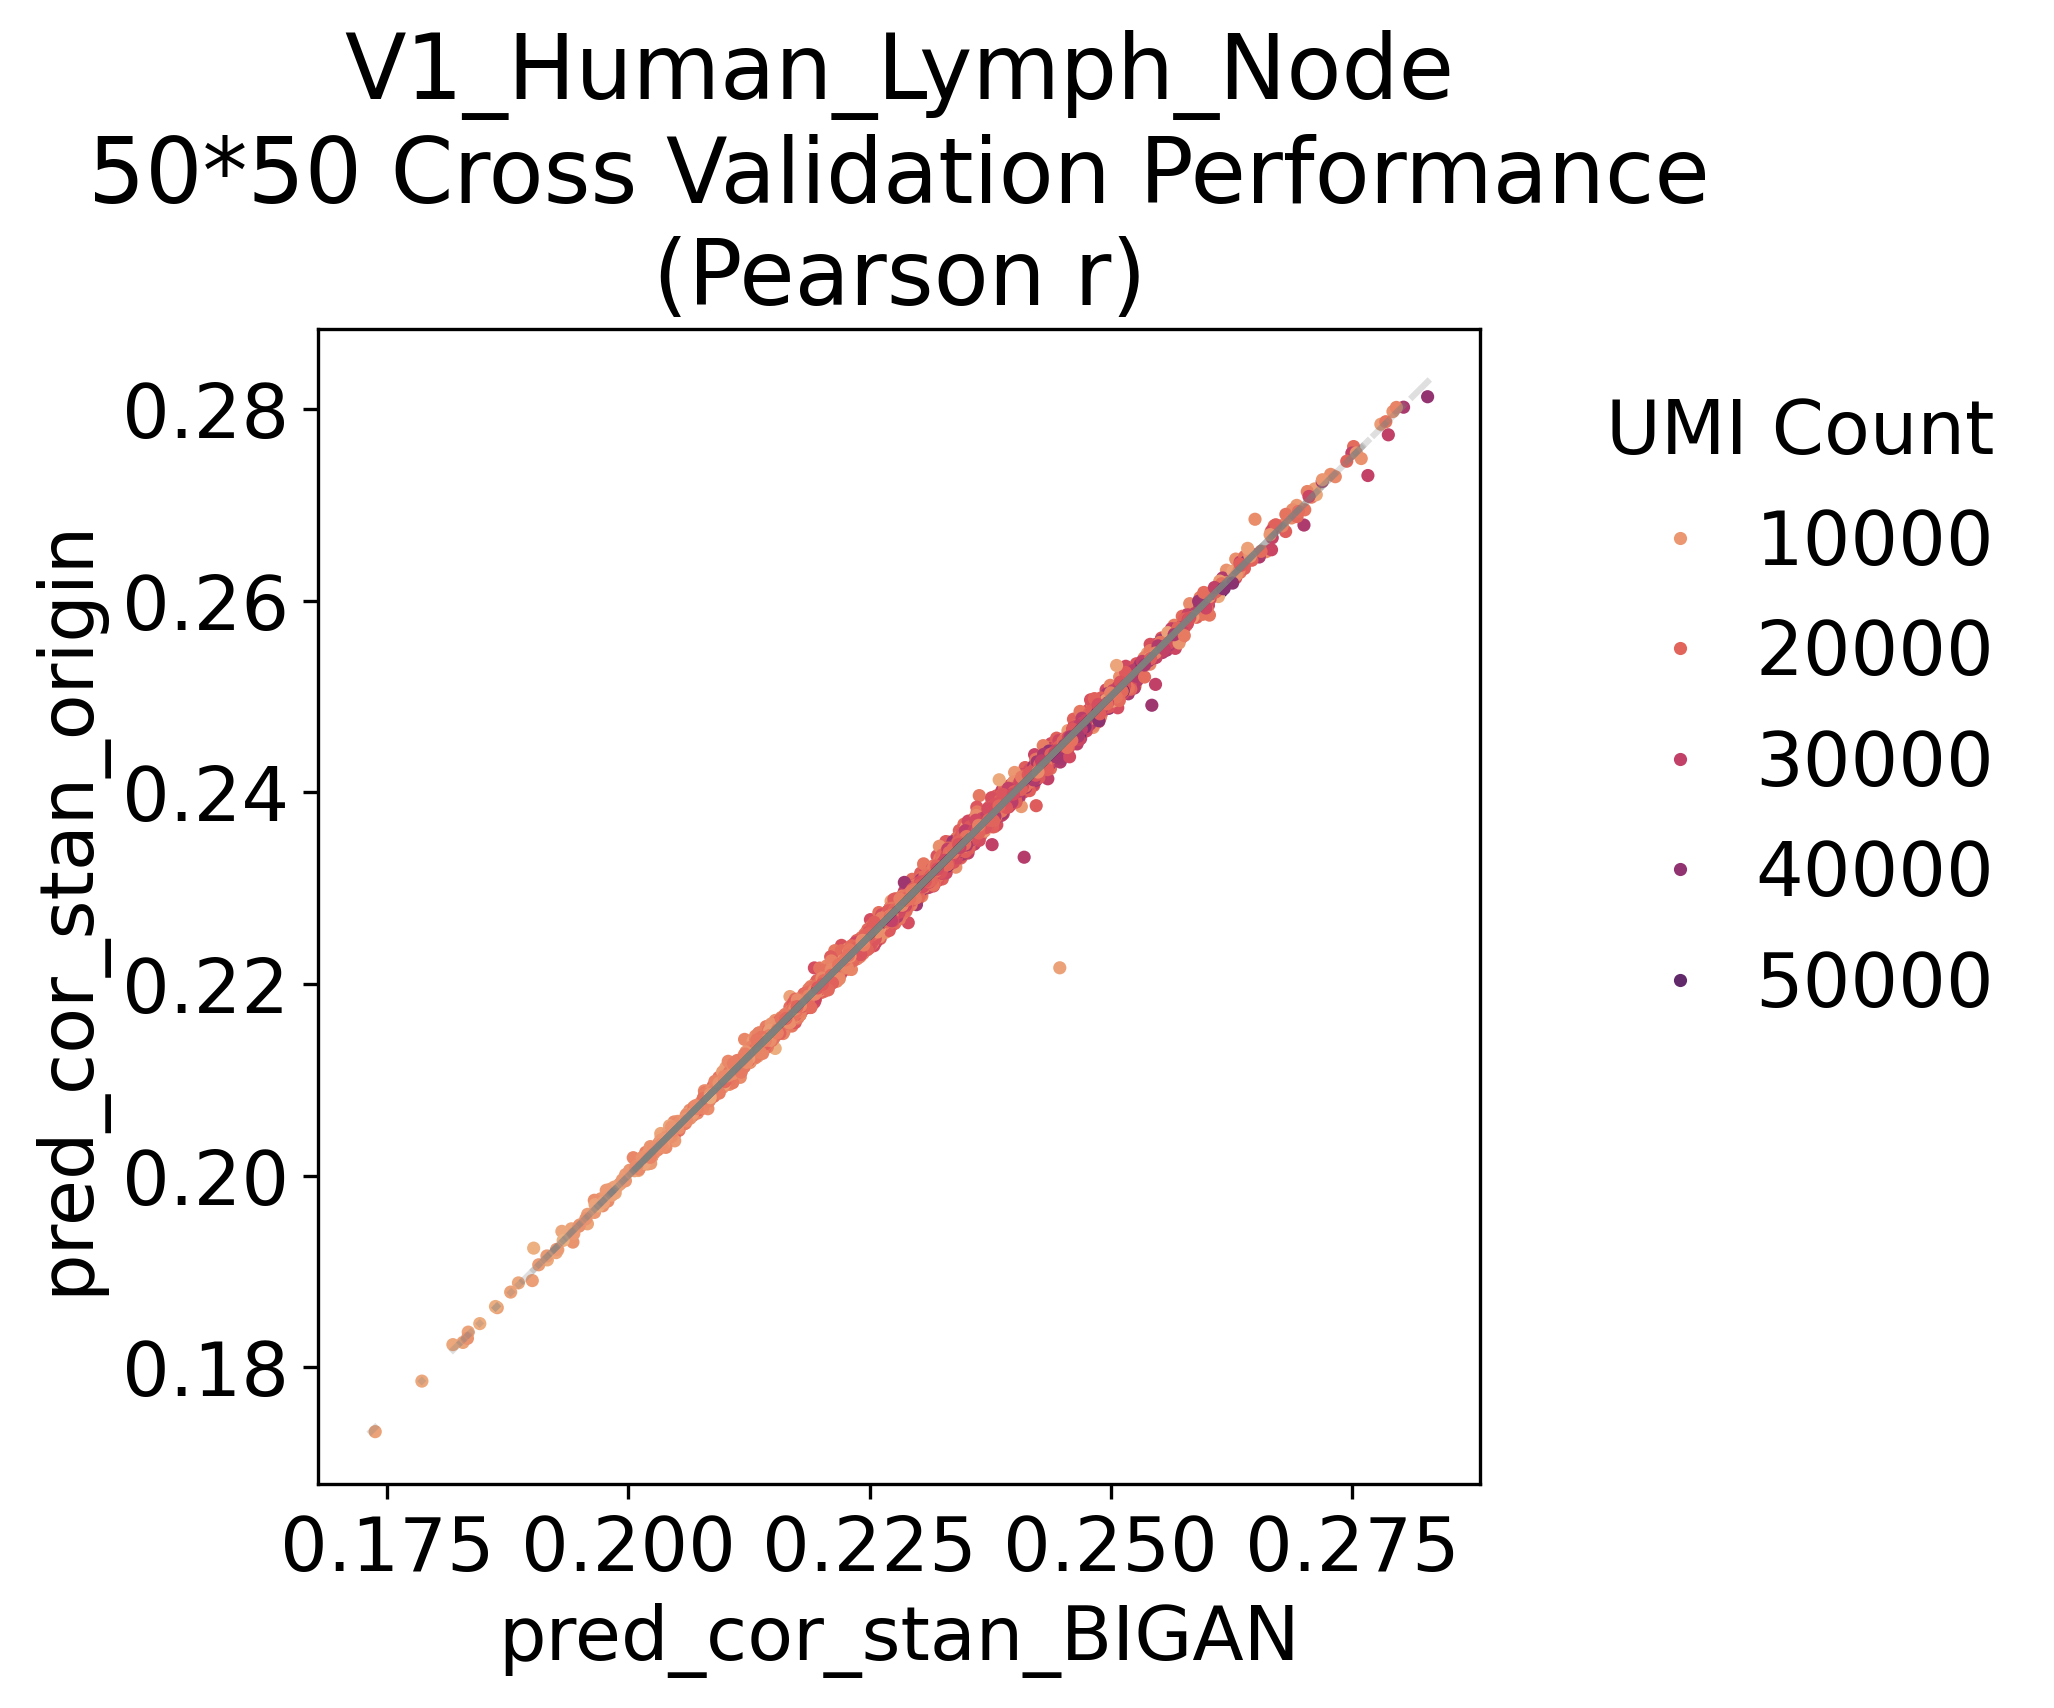

In [43]:
plot_validation(adata_filtered, xstring="pred_cor_stan_BIGAN", ystring="pred_cor_stan_origin")

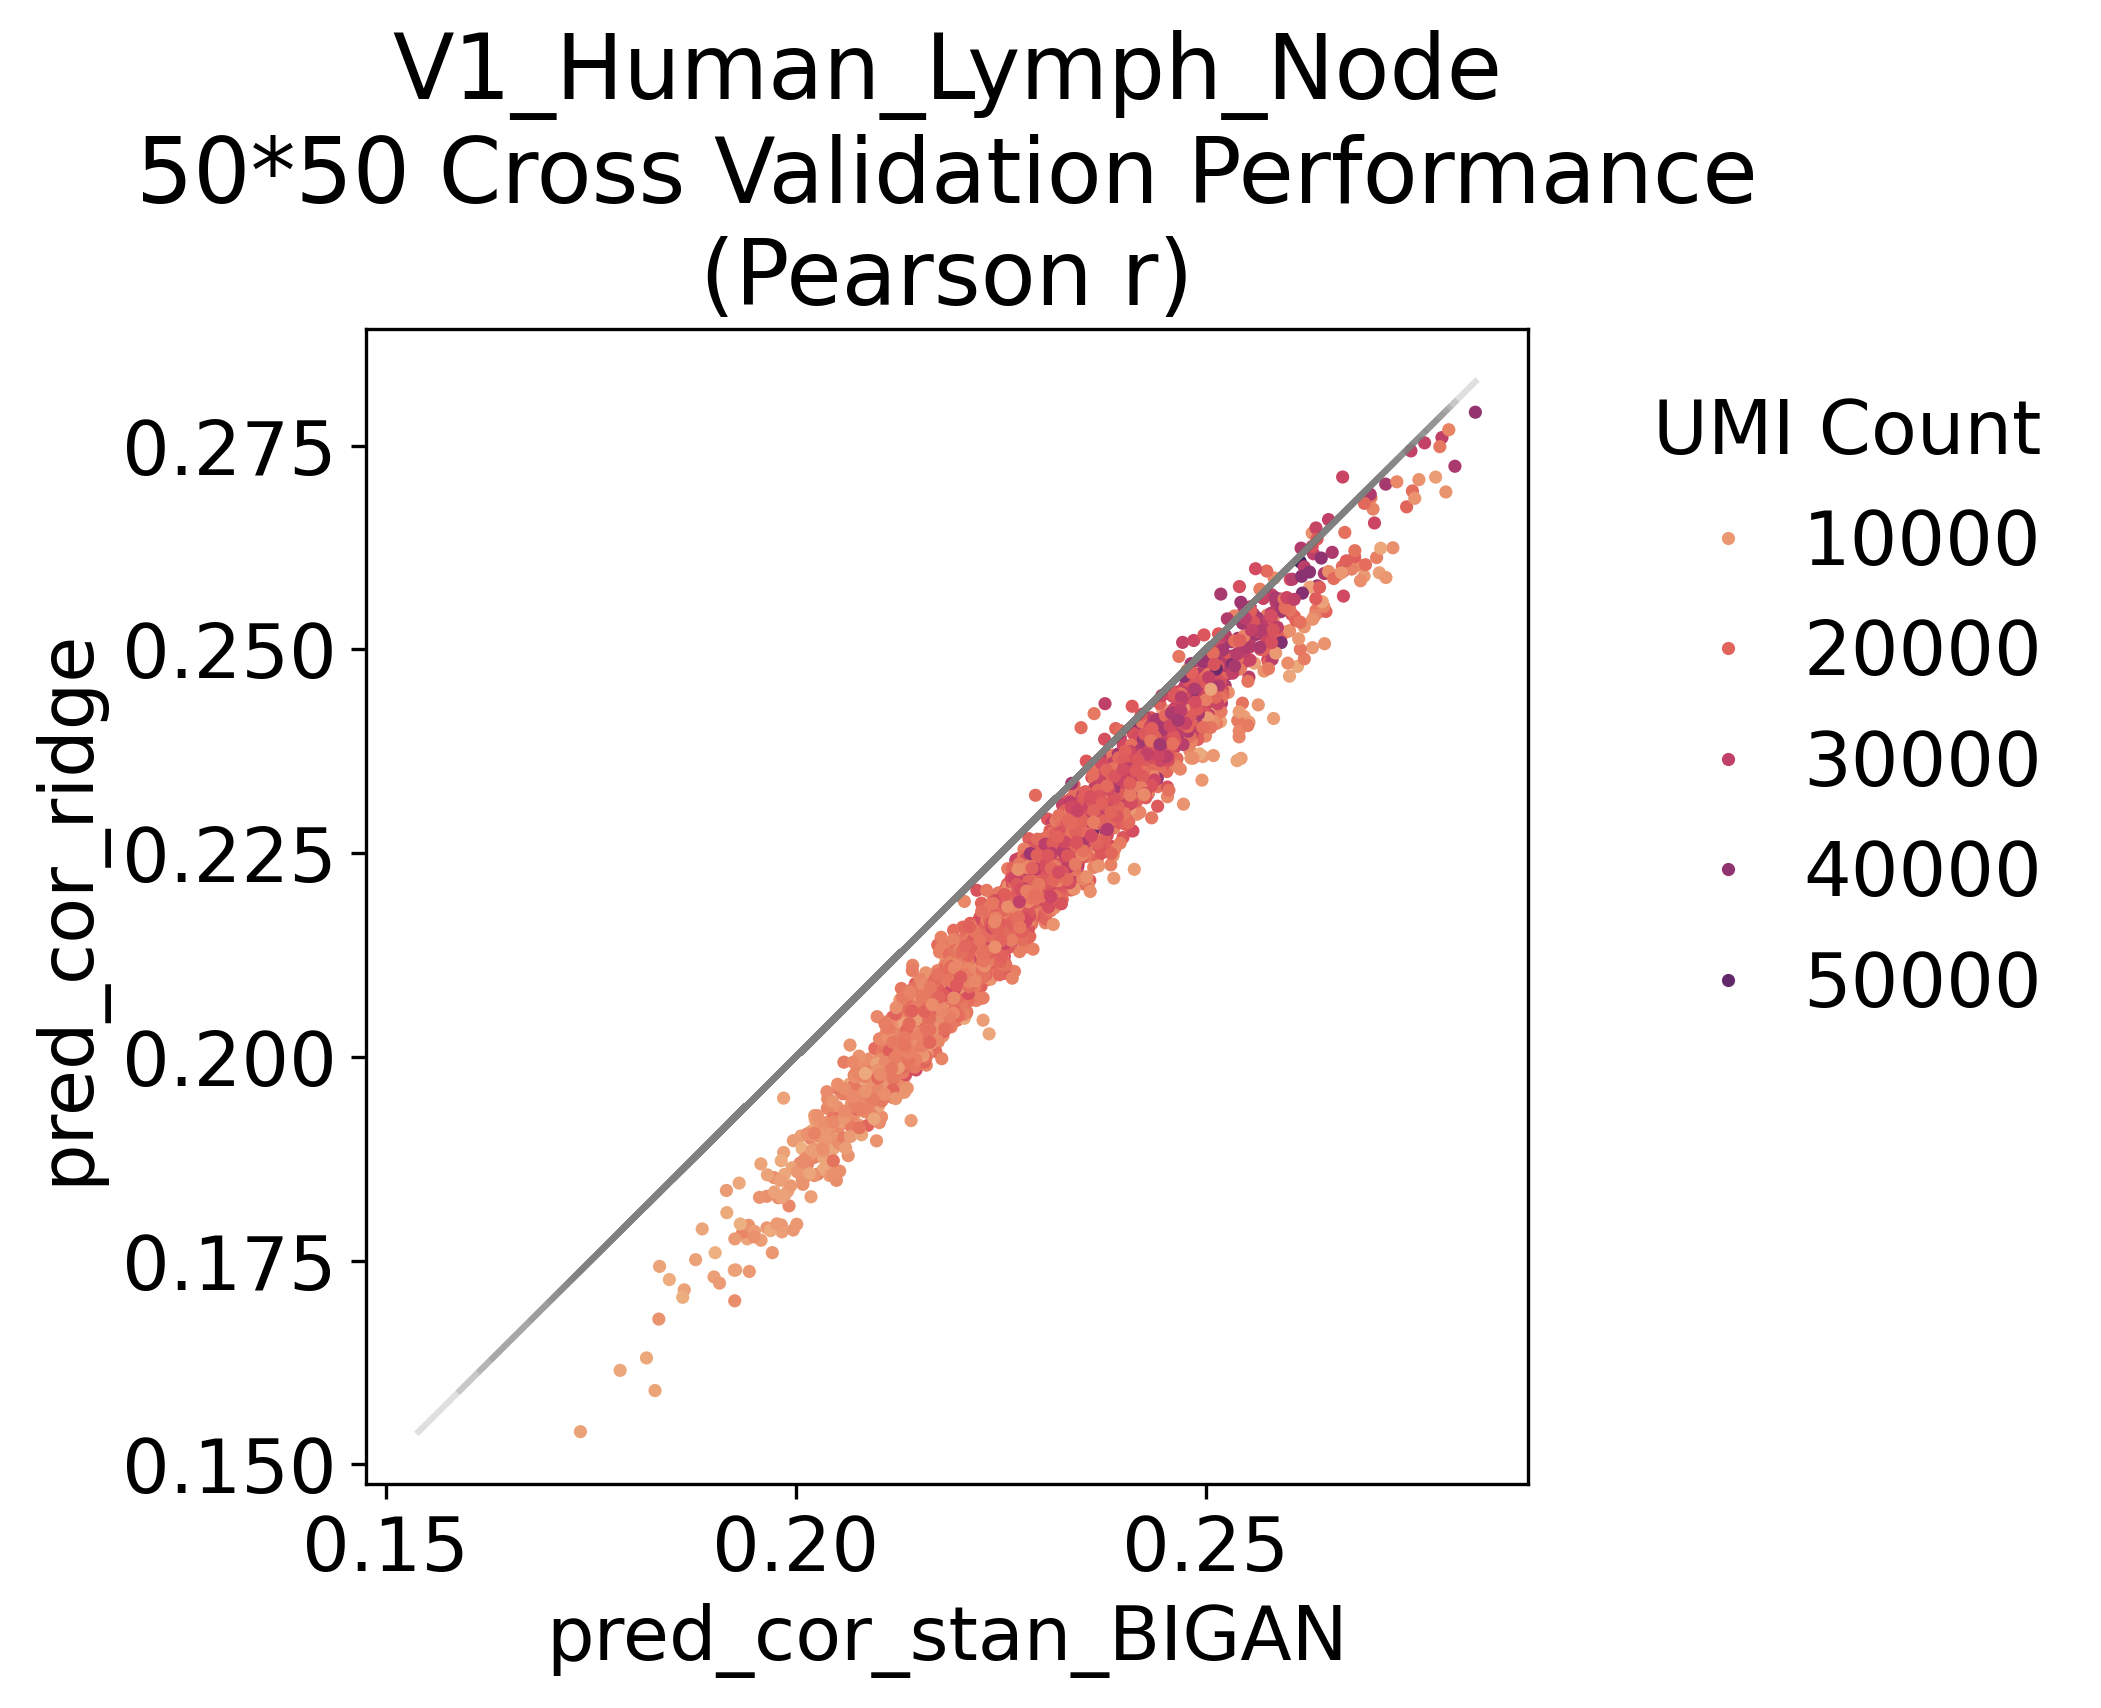

In [44]:
plot_validation(adata_filtered, xstring="pred_cor_stan_BIGAN", ystring="pred_cor_ridge")